# Introduction

Here I create a lower dimensional embedding of the genetic distance matrix that was generated from freemuxlet, for both mRNA and ATAC. Then I explore the embeddings, coloring by various covariates.

# Setup

In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix

import gzip
import itertools as it
import umap
from clue_helper import demux as clue_demux
from clue_helper import utils as clue_utils

Explicitly show UMAP version, since we're now directly using the module instead of operating through the Scanpy API.

In [2]:
umap.__version__

'0.4.6'

In [3]:
sc.settings.set_figure_params(dpi=80)

In [4]:
mountpoint = '/data/clue_test/'
prefix_atac = mountpoint + 'amo/atac/'
prefix_mrna = mountpoint + 'amo/mrna/'

# Generate Pairwise Distance Matrices

Number of cells that were used to filter the BAM files from ATAC and RNA. 
* RNA barcodes were determined using the filtered barcodes from cellranger and the noise removal as outlined in `<mountpoint>/amo/mrna/process1.ipynb`. 
* The ATAC barcodes were determined using the FRIP vs UMI as outlined in `<mountpoint>/amo/atac/extract_bcs.ipynb`.

In [8]:
atac_num = 53568
mrna_num = 95135

Generate distance matrices (`.npy` objects) from the genotype calling (pairwise distances stored in `ldist.txt`) done by freemuxlet using the following at the command line. Note that this requires a large amount of memory, and the files were transferred to a 128 GiB memory machine to run.

```
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools as it
import gzip

chunksize = 10000000
reader = pd.read_csv('freemux.ldist.gz', sep='\t', usecols=[0, 1, 8], dtype={'ID1':int, 'ID2':int, 'LDIFF':np.float}, chunksize=chunksize)
ldiffs = list()
for chunk in tqdm(reader, total=150):
    ldiffs.append(chunk)

ldiffs_df = pd.concat(ldiffs, axis=0)

ids = ldiffs_df[['ID1', 'ID2']].values
vals = ldiffs_df['LDIFF'].values

arr = np.zeros((53568, 53568), dtype=np.float)
arr = np.zeros((95135, 95135), dtype=np.float)

for (id1, id2), val in tqdm(zip(ids, vals), total=ldiffs_df.shape[0]):
    if id1 > id2:
        arr[id2, id1] = val
    else:
        arr[id1, id2] = val

def write_to_file(arr, i):
    with open('ldist_%d.txt' % i, 'w') as file:
        for j in arr:
            _ = file.write(str(j) + '\n')

max_jobs = 80

arr_flat = np.concatenate([arr[i, i:] for i in range(95135)])

idxs = np.int64(np.linspace(0, arr_flat.shape[0], num=max_jobs + 1))

slices = [slice(idxs[i-1], idxs[i]) for i in range(1, len(idxs))]

par_outs = Parallel(n_jobs=max_jobs)(delayed(write_to_file)(arr_flat[sl], k) for (sl, k) in zip(slices, range(len(slices))))


with gzip.open('ldist.txt.gz', 'wt') as file:
    for i, j in tqdm(it.combinations_with_replacement(range(53568), r=2), total=sum(range(53568))):
        _  = file.write(str(arr[i, j]) + '\n')

with gzip.open('ldist.txt.gz', 'wt') as file:
    for i, j in tqdm(it.combinations_with_replacement(range(95135), r=2), total=sum(range(95135))):
        _ = file.write(str(arr[i, j]) + '\n')

```

Need to make sure which is correct to reproduce the outputs.

In [7]:
# atac_pdist = np.zeros((atac_num, atac_num), dtype=np.float16)
# mrna_pdist = np.zeros((mrna_num, mrna_num), dtype=np.float16)

The next cells take hours. I could've figured out how to split the files at the command line and parallelized in the reading in, but I figured I'd just do other stuff while I wait to read in. 

In [2]:
# with open(prefix_atac + 'demux/aux/ldist.txt', 'r') as file:
#     for (i, j), line in tqdm(zip(it.combinations_with_replacement(range(atac_num), r=2), file), total=sum(range(atac_num + 1))):
#         val = np.float16(line.strip())
#         atac_pdist[i, j] = val
#         atac_pdist[j, i] = val

In [3]:
# with open(prefix_mrna + 'demux/aux/ldist.txt', 'r') as file:
#     for (i, j), line in tqdm(zip(it.combinations_with_replacement(range(mrna_num), r=2), file), total=sum(range(mrna_num + 1))):
#         val = np.float16(line.strip())
#         mrna_pdist[i, j] = val
#         mrna_pdist[j, i] = val

## Intermediate Export/Import

I also add an offset to make sure negative distances are set to zero and everything else is shifted proportionally.

In [9]:
# np.save(prefix_atac + 'demux/aux/atac_pdist.npy', atac_pdist)
# atac_pdist = np.load(prefix_atac + 'demux/aux/atac_pdist.npy')

# atac_pdist -= atac_pdist.min()
# np.save(prefix_atac + 'demux/aux/atac_pdist_offset.npy', atac_pdist)
atac_pdist = np.load(prefix_atac + 'demultiplex/aux/atac_pdist_offset.npy')

In [10]:
# np.save(prefix_mrna + 'demux/aux/mrna_pdist.npy', mrna_pdist)
# mrna_pdist = np.load(prefix_mrna + 'demux/aux/mrna_pdist.npy')

# mrna_pdist -= mrna_pdist.min()
# np.save(prefix_mrna + 'demux/aux/mrna_pdist_offset.npy', mrna_pdist)
mrna_pdist = np.load(prefix_mrna + 'demultiplex/aux/mrna_pdist_offset.npy')

In [ ]:
# for i in tqdm(range(atac_num)):
#     atac_pdist[i, i] = 0

In [ ]:
# for i in tqdm(range(mrna_num)):
#     mrna_pdist[i, i] = 0

# ATAC

## UMAP, Intermediate Import/Export

In [11]:
# U = umap.UMAP(metric='precomputed')
# atac_XY = U.fit_transform(atac_pdist)

In [13]:
# np.save(prefix_atac + 'demux/aux/atac_pdist_umap_XY.npy', atac_XY)
atac_XY = np.load(prefix_atac + 'demultiplex/aux/atac_XY_new_offset_umap.npy')

In [38]:
atac_geno_adata = sc.AnnData(X=np.zeros((atac_num, 1), dtype=int), 
                             var=pd.DataFrame(index=['null']),
                             obs=pd.DataFrame(index=map(str, range(atac_num))))

In [39]:
atac_geno_adata.obsm['X_umap'] = atac_XY

## Visualize

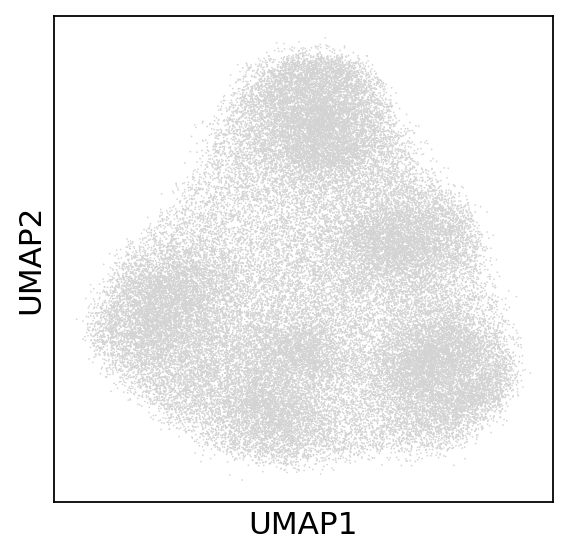

In [40]:
sc.pl.umap(atac_geno_adata)

In [41]:
freemux_atac = pd.read_csv(prefix_atac + 'demultiplex/freemux/freemux.clust1.samples.gz', sep='\t')
freemux_atac.index = freemux_atac.index.astype('str')

In [42]:
concat_obs = sc.read_h5ad(prefix_atac + 'h5ads/concat_5.h5ad').obs
obs_join = concat_obs[['cond', 'ct1']].copy()

In [44]:
atac_geno_adata.obs = atac_geno_adata.obs.join(freemux_atac).set_index('BARCODE').join(obs_join)
atac_geno_adata.obs['BEST.GUESS'] = atac_geno_adata.obs['BEST.GUESS'].astype('category')

In [45]:
donor_colors = dict([(str(i),mpl.colors.hex2color(j)) for i, j in enumerate(sc.pl.palettes.default_20[:5])])

In [46]:
for i, j in it.combinations_with_replacement(list(map(str,range(5)))[::-1], r=2):
    donor_colors[','.join((i, j))] = np.mean([donor_colors[i], donor_colors[j]], axis=0)

In [47]:
atac_geno_adata.uns['BEST.GUESS_colors'] = [mpl.colors.rgb2hex(donor_colors[i]) for i in atac_geno_adata.obs['BEST.GUESS'].cat.categories]

/home/ssm-user/miniconda3/envs/clue_test/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'DROPLET.TYPE' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'NEXT.GUESS' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'DBL.BEST.GUESS' as categorical


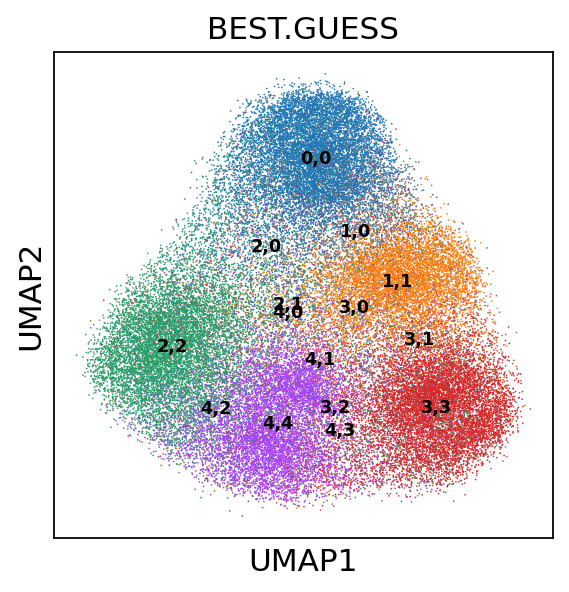

In [48]:
sc.pl.umap(atac_geno_adata[atac_geno_adata.obs.sample(frac=1).index], color=['BEST.GUESS'], legend_loc='on data', legend_fontsize=8)

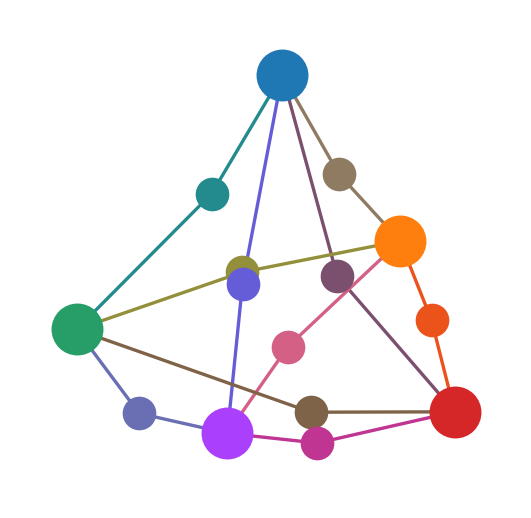

In [54]:
meds_list = list()
for donor_assign in atac_geno_adata.obs['BEST.GUESS'].cat.categories:
    meds = np.median(atac_geno_adata.obsm['X_umap'][atac_geno_adata.obs['BEST.GUESS'] == donor_assign], axis=0)
    meds_list.append([*donor_assign.split(','), *meds])
    da_split = donor_assign.split(',')
    if da_split[0] == da_split[1]:
        s = 500
    else:
        s = 200
    plt.scatter(*meds, color=donor_colors[donor_assign], s=s)
meds_df = pd.DataFrame(meds_list, columns=['d1', 'd2', 'X', 'Y'])
for d1, d2 in it.combinations(map(str, range(5)), r=2):
    lines = meds_df[meds_df['d1'].str.contains(d1 + '|' + d2) & meds_df['d2'].str.contains(d1 + '|' + d2)]
    plt.plot(*lines[['X', 'Y']].T.values, color=donor_colors[d2 + ',' + d1], zorder=-1)
plt.grid(False)
ax = plt.gca()
ax.set_frame_on(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlim(clue_utils.dilate_range(ax.get_xlim(), 0.1))
ax.set_ylim(clue_utils.dilate_range(ax.get_ylim(), 0.1));

/home/ssm-user/miniconda3/envs/clue_test/lib/python3.6/site-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'DROPLET.TYPE' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'NEXT.GUESS' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'DBL.BEST.GUESS' as categorical


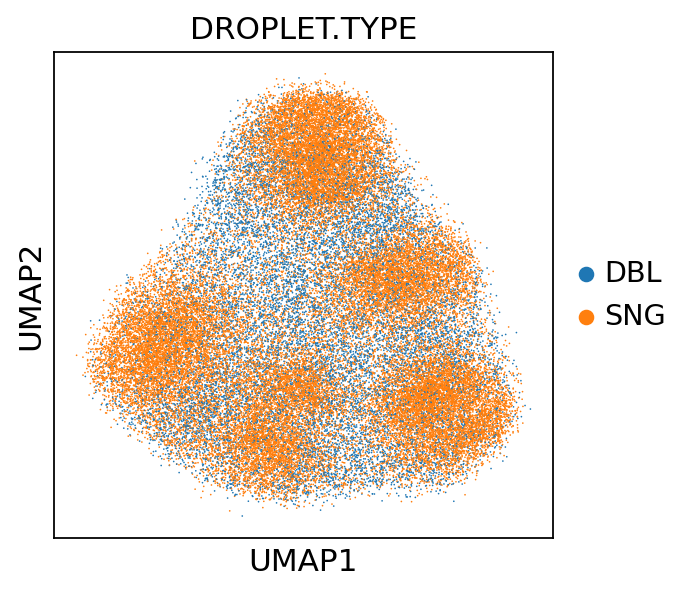

In [51]:
sc.pl.umap(atac_geno_adata[atac_geno_adata.obs.sample(frac=1).index], color=['DROPLET.TYPE'])

... storing 'DROPLET.TYPE' as categorical
... storing 'NEXT.GUESS' as categorical
... storing 'DBL.BEST.GUESS' as categorical


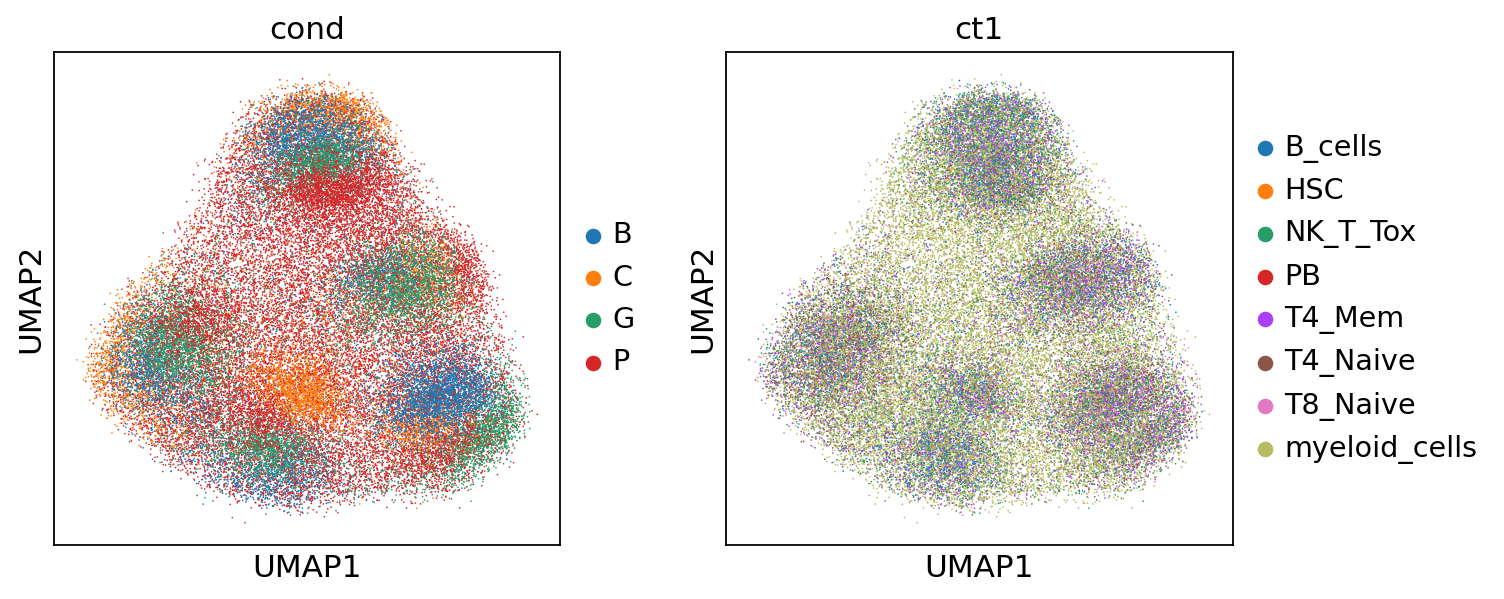

In [52]:
sc.pl.umap(atac_geno_adata, color=['cond', 'ct1'])

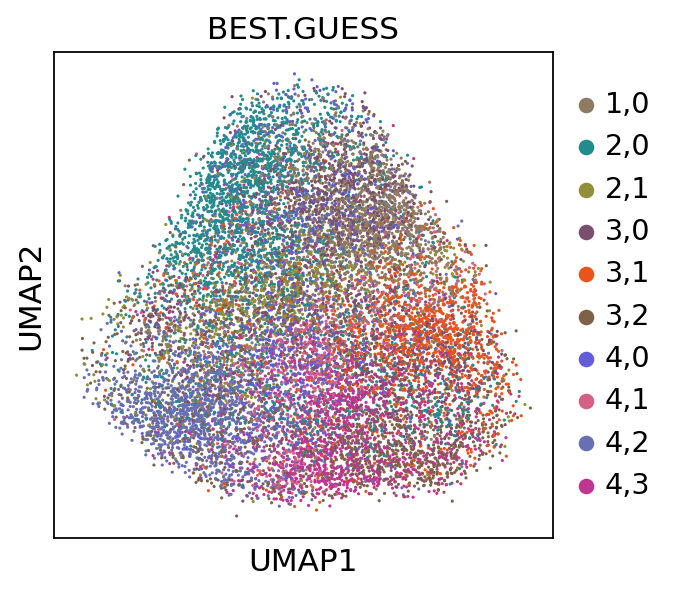

In [53]:
sc.pl.umap(atac_geno_adata[atac_geno_adata.obs['DROPLET.TYPE'] == 'DBL'], color=['BEST.GUESS'])

# RNA

## UMAP, Intermediate Import/Export

In [55]:
# U = umap.UMAP(metric='precomputed')
# mrna_XY = U.fit_transform(mrna_pdist)

In [9]:
# np.save(prefix_mrna + 'demux/aux/mrna_pdist_umap_XY.npy', mrna_XY)
mrna_XY = np.load(prefix_mrna + 'demultiplex/aux/mrna_XY_new_offset_umap.npy')

In [10]:
mrna_geno_adata = sc.AnnData(X=np.zeros((mrna_num, 1), dtype=int), 
                             var=pd.DataFrame(index=['null']),
                             obs=pd.DataFrame(index=map(str, range(mrna_num))))

In [11]:
mrna_geno_adata.obsm['X_umap'] = mrna_XY

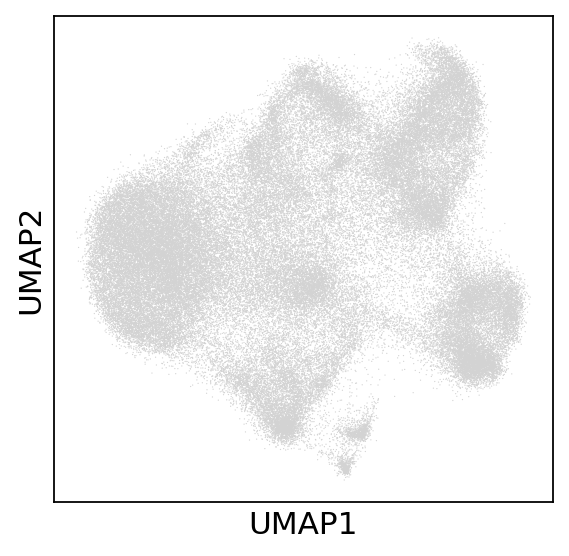

In [12]:
sc.pl.umap(mrna_geno_adata)

In [13]:
freemux_mrna = pd.read_csv(prefix_mrna + 'demultiplex/freemux/freemux.clust1.samples.gz', sep='\t')
freemux_mrna.index = freemux_mrna.index.astype('str')

In [14]:
concat_obs = sc.read_h5ad(prefix_mrna + 'h5ads/concat_3.h5ad').obs
obs_join = concat_obs[['cond', 'leiden']].copy()
obs_join.index = obs_join.index.str.replace('-[0-9]$', '')

In [15]:
mrna_geno_adata.obs = mrna_geno_adata.obs.join(freemux_mrna).set_index('BARCODE').join(obs_join)

... storing 'DROPLET.TYPE' as categorical
... storing 'BEST.GUESS' as categorical
... storing 'NEXT.GUESS' as categorical
... storing 'DBL.BEST.GUESS' as categorical


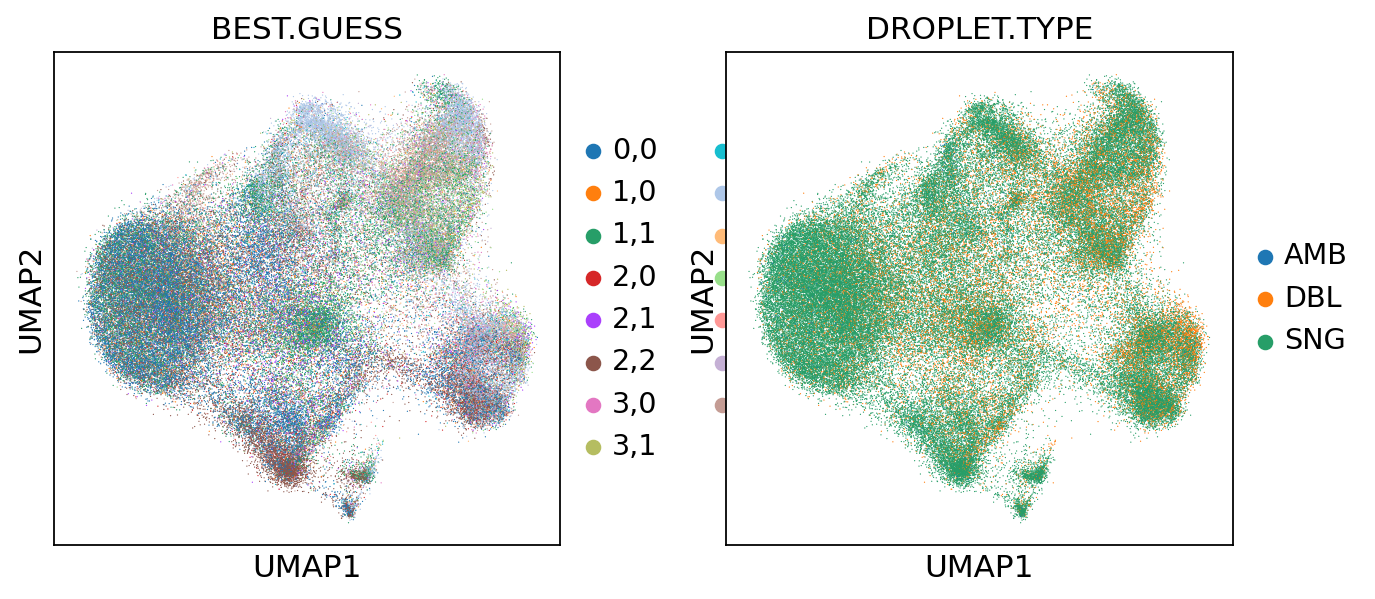

In [16]:
sc.pl.umap(mrna_geno_adata, color=['BEST.GUESS', 'DROPLET.TYPE'])

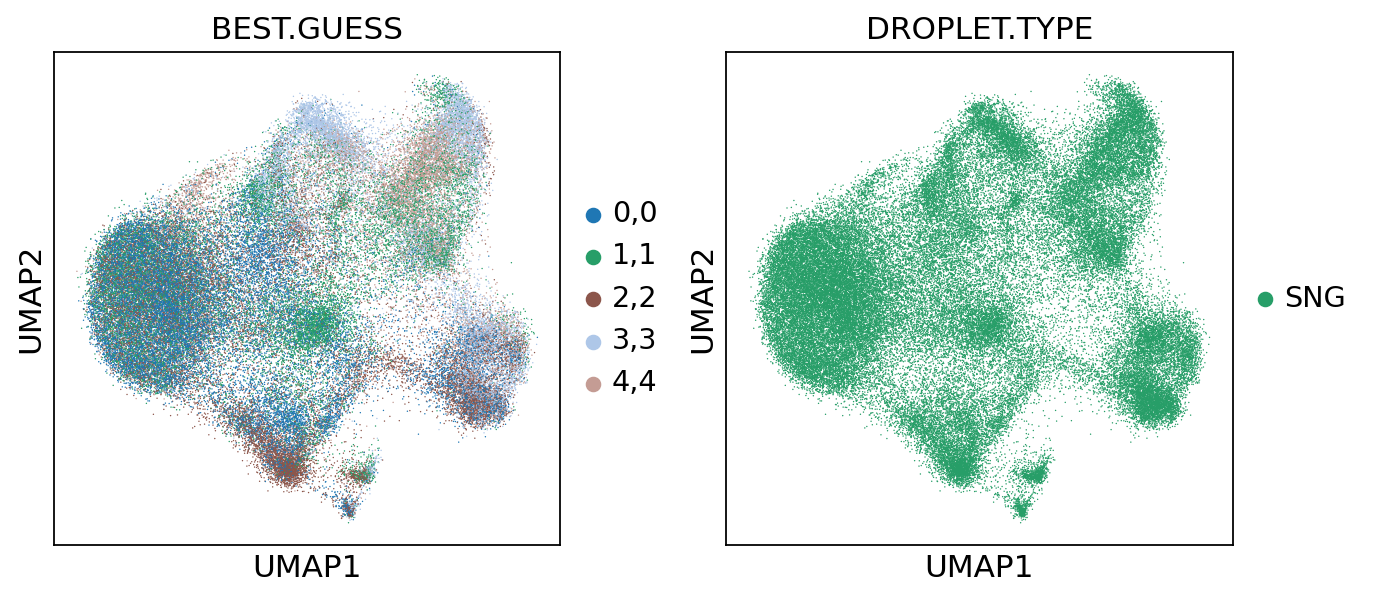

In [17]:
sc.pl.umap(mrna_geno_adata[mrna_geno_adata.obs['DROPLET.TYPE'] == 'SNG'], color=['BEST.GUESS', 'DROPLET.TYPE'])

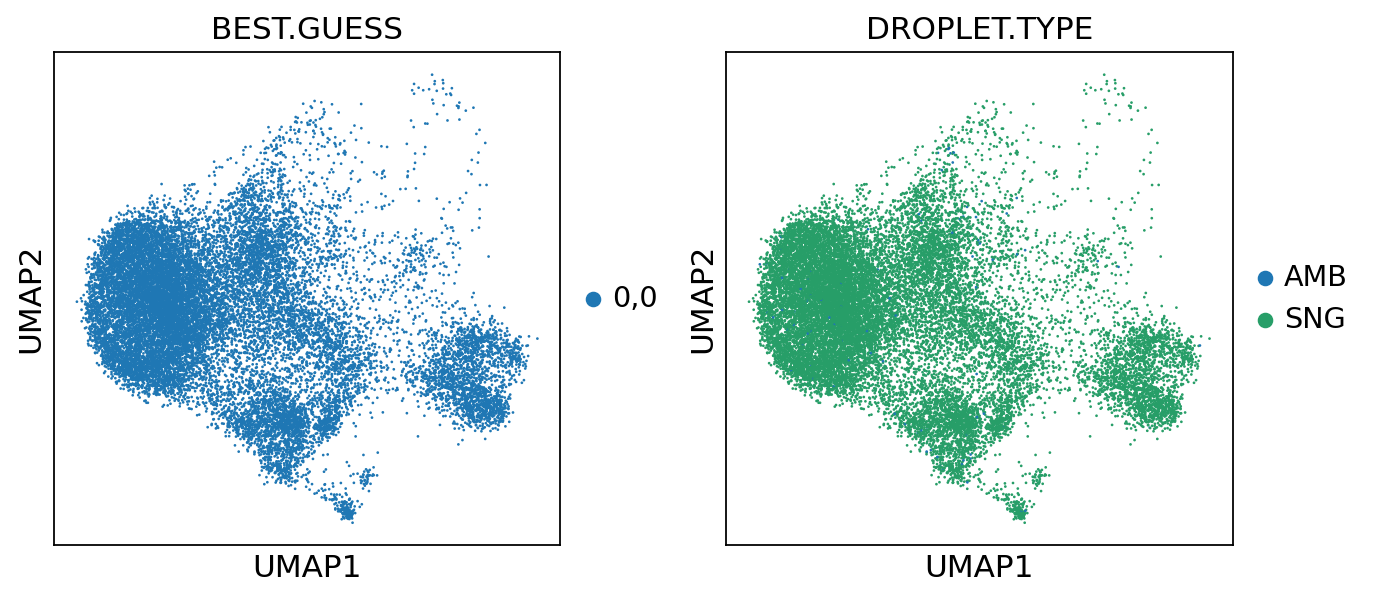

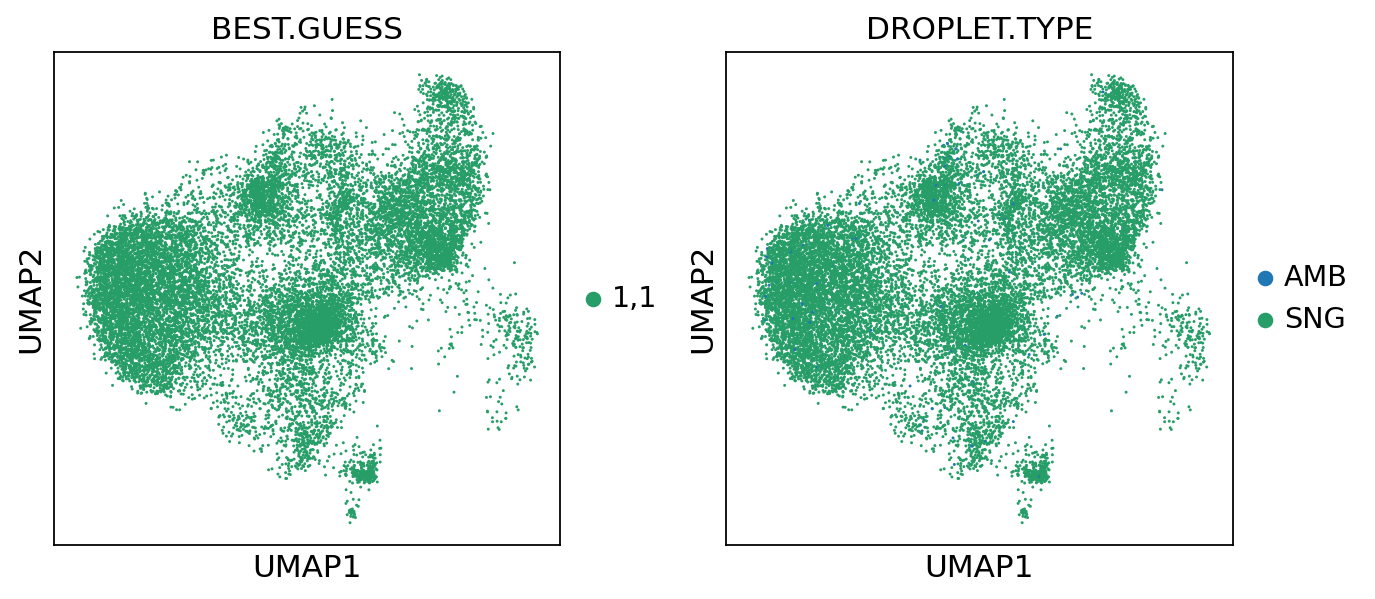

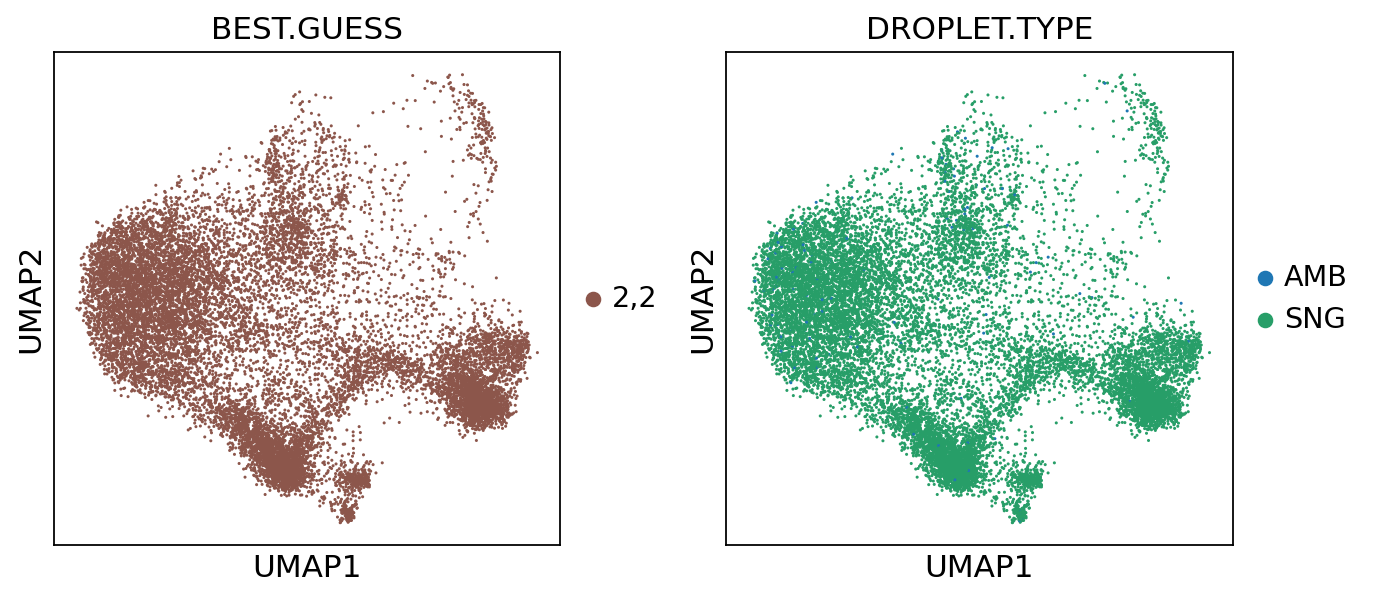

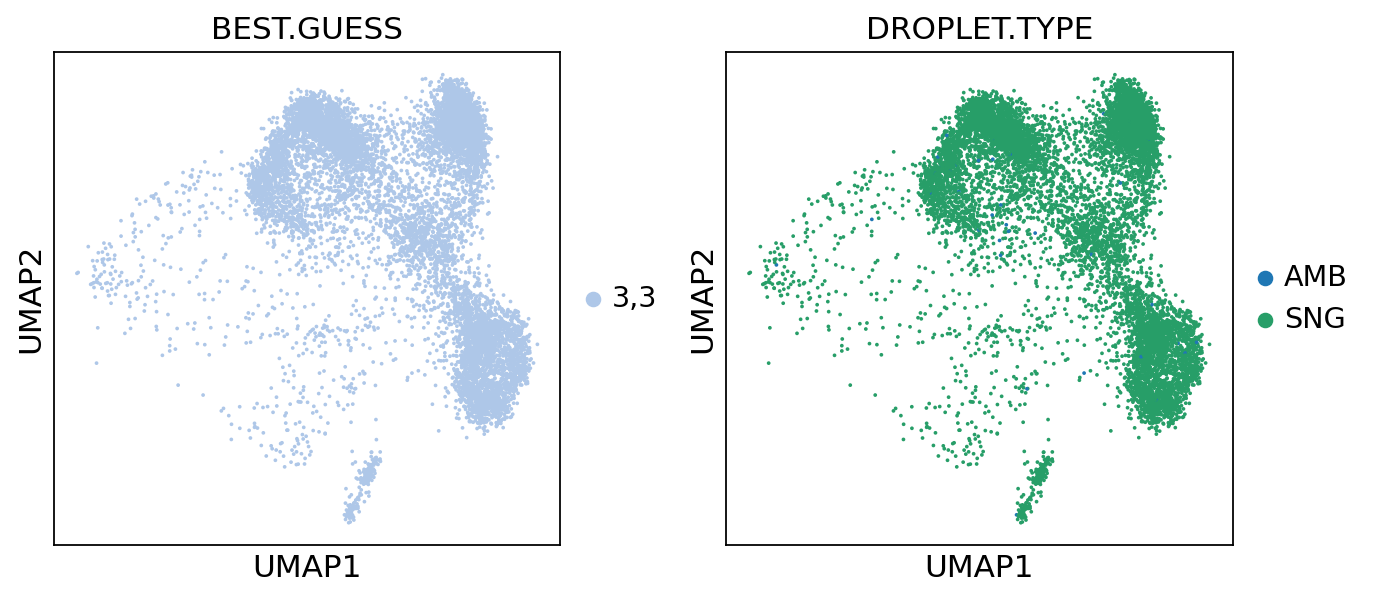

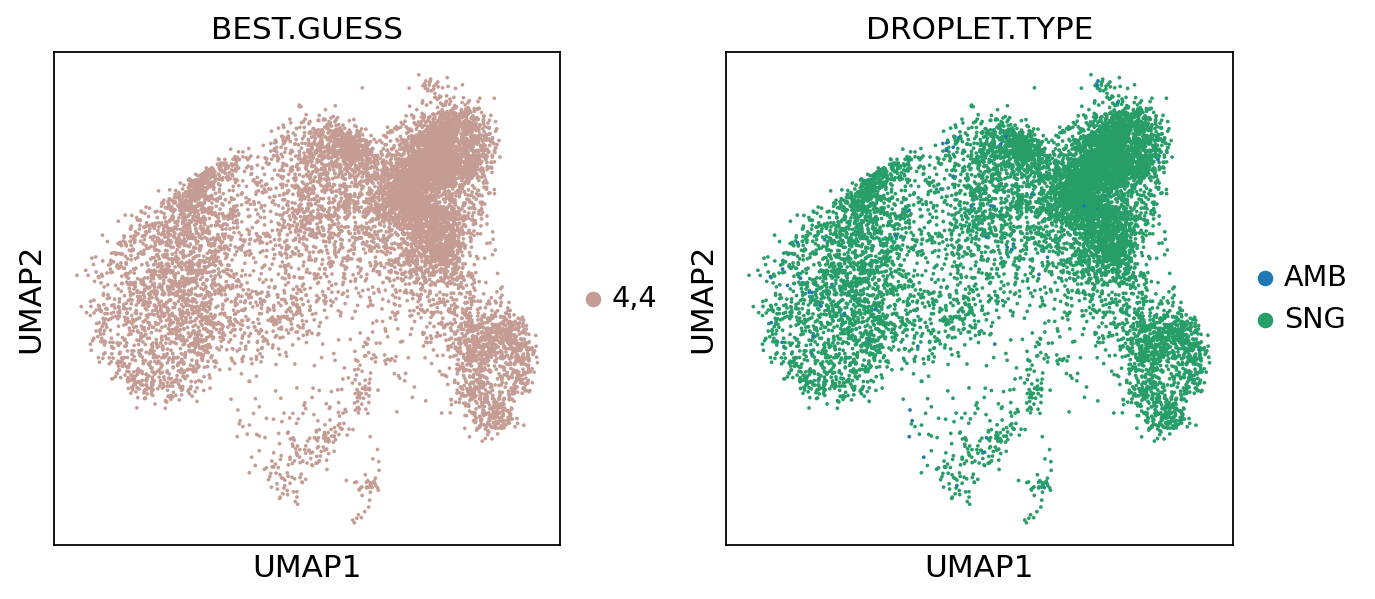

In [31]:
for i in [','.join(j) for j in zip(*it.repeat(list(map(str,range(5))), 2))]:
    sc.pl.umap(mrna_geno_adata[mrna_geno_adata.obs['BEST.GUESS'] == i], color=['BEST.GUESS', 'DROPLET.TYPE'])

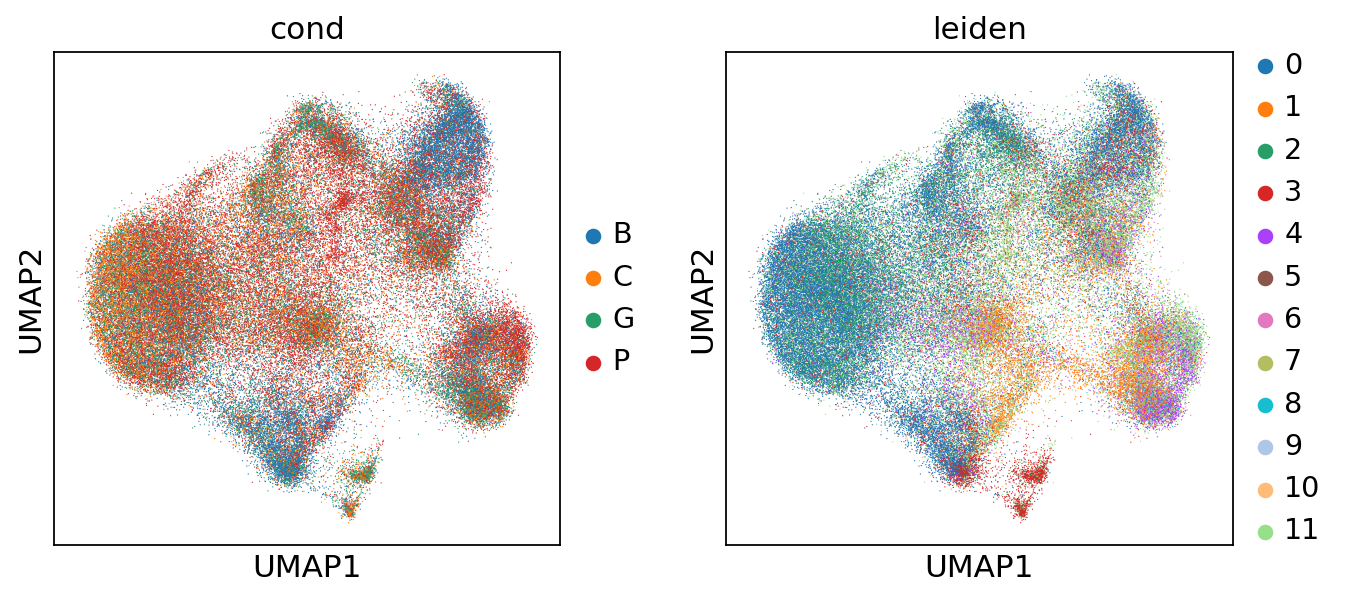

In [32]:
sc.pl.umap(mrna_geno_adata, color=['cond', 'leiden'])